# 2D Variational MD

This jupyter notebook is the one that I used to developed the self consistent procedure. It contains many benchmarks for the code. I keep everything here in case I need something that I have already written. If you are interested in the final plots, just look at the notebooks called "2D_VariationalMD_2a" for the first potential and "2D_VariationalMD_2a" for the second one. In this notebook I work only on the first potential.

## Libraries

In [1]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Linrary for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

The following cell makes the fontsize of the plot a bit bigger.

In [2]:
plt.rcParams.update({'font.size': 16})

Run the following line without "#" in order to get the plots as windows in the browser (useful because it is possible to zoom the plots).

In [3]:
## Line to make plot in other windows of browser
#%matplotlib

I fix the random seed for the simulations.

In [4]:
## Seed used for the simulation
np.random.seed(42)

## Preliminary Functions

In [5]:
# Parameters of the potentials
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

First I copy the functions of the potential, force and the state (i.e. if point is in reactant, transition or product state) from the "2D_ToyModel" codes.

In [6]:
@njit(fastmath=True)
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit(fastmath=True)
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])

@njit(fastmath=True)
def state(q, R=0.2): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp1 = q[0]**2 + 1.15**2 + q[1]**2
    tmp2 = 2.0*1.15*q[0]
    if tmp1 - tmp2 < R**2:
        # Product state
        state = 1
    if tmp1 + tmp2 < R**2:
        # Reactant state
        state = -1
    return state

## Committor guesses

My first guess of committor is a linear one. I have two classes of functions: "qlin" is a function that evaluates the committor given a point in phase space, "dqlin" evaluates the gradient of the linear committor at that point. The codes with a 2 or a 3 are defined in bigger regions, but they have the problem that we have a discontinuities on the border of the states. I keep them because in future maybe I will study how discontinuities can influence the final results. 

I defined the reactant and product states as the circles of radii $R = 0.2$ around the points $\mathbf{x}_R = (-1.15,0)$ and $\mathbf{x}_P = (1.15,0)$.

In [7]:
## First guess of the committor function: q increases linearly along x
# The committor starts from the inner edges of the states
@njit(fastmath=True)
def qLin(q, R=0.2):
    if q[0] <= R-1.15:
        return 0
    elif q[0] >= 1.15-R:
        return 1
    else:
        return q[0]/(2.0*(1.15-R))+0.5

#Gradient of the first committor guess
@njit(fastmath=True)
def dqLin(q, R=0.2):
    if q[0] < R-1.15 or q[0] > 1.15-R:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.15-R)), 0.0

# The committor starts from the outerr edges of the states
@njit(fastmath=True)
def qLin2(q, R=0.2):  
    if q[0] <= -R-1.15:
        return 0
    elif q[0] >= 1.15+R:
        return 1
    elif (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1
    else:
        return q[0]/(2.0*(1.15+R))+0.5

@njit(fastmath=True)
def dqLin2(q, R=0.2):
    if q[0] < -R-1.15 or q[0] > 1.15+R or (q[0] - 1.15)**2 + q[1]**2 <= R**2 or (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.15+R)), 0.0
    
    
# The committor starts from the center of the states
@njit(fastmath=True)
def qLin3(q, R=0.2):
    if q[0] <= -1.15:
        return 0
    elif q[0] >= 1.15:
        return 1
    elif (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1
    else:
        return q[0]/(2.0*1.15)+0.5

@njit(fastmath=True)
def dqLin3(q, R=0.2):
    if q[0] < -1.15 or q[0] > 1.15 or (q[0] - 1.15)**2 + q[1]**2 <= R**2 or (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*1.15), 0.0    

Now I plot the committor and its gradient to see if the functions are defined correctly. The reactant and product state are colored with a darker color (but in this way the colorbar on the sides is a bit off). If I think of a better way to implement this, I will fix this problem.

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-a0250b32a482>", line 4:
@njit(fastmath=True)
def qLin(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


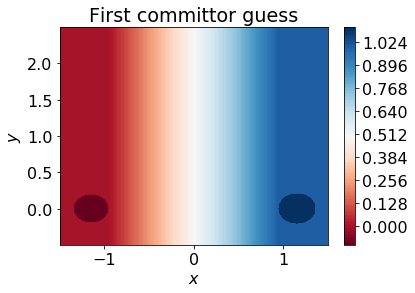

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqLin'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-a0250b32a482>", line 14:
@njit(fastmath=True)
def dqLin(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


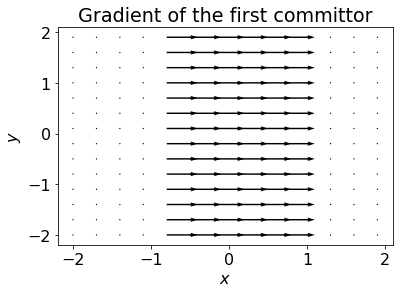

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-a0250b32a482>", line 22:
@njit(fastmath=True)
def qLin2(q, R=0.2):  
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


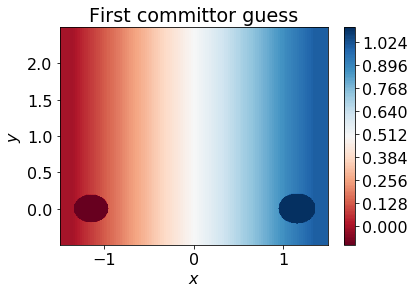

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqLin2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-a0250b32a482>", line 35:
@njit(fastmath=True)
def dqLin2(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


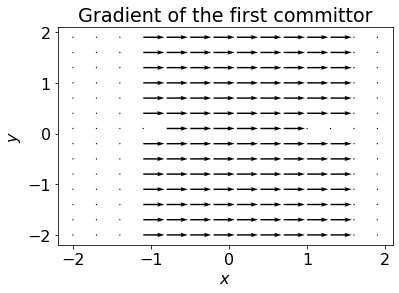

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin3'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-a0250b32a482>", line 44:
@njit(fastmath=True)
def qLin3(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


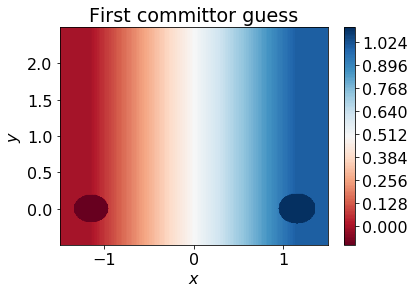

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqLin3'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-a0250b32a482>", line 57:
@njit(fastmath=True)
def dqLin3(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


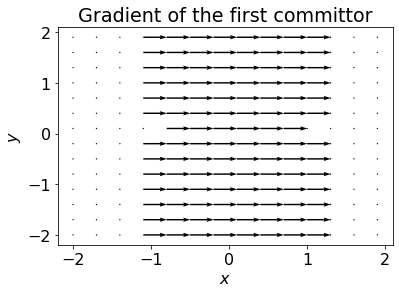

In [8]:
## Radius for the 
R = 0.2

### Linear committor - qlin function
# Resolution of the plot
dx, dy = 0.01, 0.01
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy), slice(-1.5, 1.5 + dx, dx)]
# Evaluate the committor
G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        # Product state
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        # Reactant state
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qLin([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2.,y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
plt.colorbar()
plt.title('First committor guess')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


### Gradient of the first committor - dqlin function

# Grid of the plot
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))
# Evaluate the components of the gradient
Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        # Product state
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        # Reactant state
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqLin([x[i,j], y[i,j]], R=R)      
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
# Title and labels
plt.title("Gradient of the first committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()    

## Colour plot of the first committor guess - qlin2 function
# Resolution of the plot
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy), slice(-1.5, 1.5 + dx, dx)]
# Evaluate the committor
G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        # Product state
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        # Reactant state
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qLin2([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# contours are *point* based plots, so convert our bound into point centers
plt.figure()
plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
plt.colorbar()
plt.title('First committor guess')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

### Gradient of the first committor - dqlin2 function
# Grid of the plot
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqLin2([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the first committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()    

## Colour plot of the first committor guess
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qLin3([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point centers
cf = ax.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

## Gradient of the first committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqLin3([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the first committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()  

My second guess of committor is a circular one. Pretty much I evaluate the angle with respect to the origin (because the system is symmetric with respect to the y-axis). I use the arcos function to evaluate the angle. The codes that end with an U are the codes with a circumference in the upper half plane, instead the codes that end with a D are the codes with the circumference in the lower half plane.

In [9]:
#Second guess of the committor function: q increases along a circle
@njit(fastmath=True)
def qCircle(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else: 
        return (theta - alpha)/(np.pi - alpha)

#Gradient of the second committor guess
@njit(fastmath=True)
def dqCircle(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]>0:
            return q[1]/(q[0]**2 + q[1]**2), -q[0]/(q[0]**2 + q[1]**2)
        else:
            return -q[1]/(q[0]**2 + q[1]**2), q[0]/(q[0]**2 + q[1]**2)
        
        
@njit(fastmath=True)
def qCircleU(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] < 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)

@njit(fastmath=True)
def dqCircleU(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1] > 0.0:
            return q[1]/(q[0]**2 + q[1]**2), -q[0]/(q[0]**2 + q[1]**2)
        else:
            return 0.0, 0.0            
                
@njit(fastmath=True)
def qCircleD(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] > 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)   
        
@njit(fastmath=True)
def dqCircleD(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]< 0.0:
            return -q[1]/(q[0]**2 + q[1]**2), q[0]/(q[0]**2 + q[1]**2)
        else:
            return 0.0, 0.0

Now I plot the circular committor and its gradient.

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircle'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b5d83c2f9bf5>", line 3:
@njit(fastmath=True)
def qCircle(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


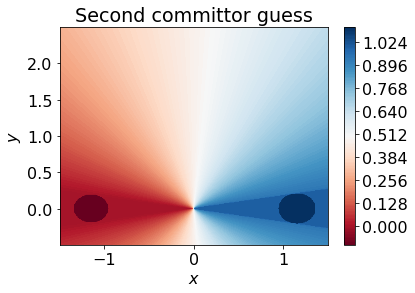

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqCircle'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b5d83c2f9bf5>", line 17:
@njit(fastmath=True)
def dqCircle(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


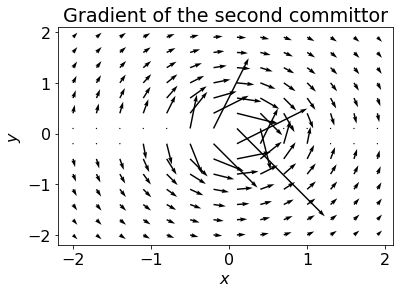

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircleU'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b5d83c2f9bf5>", line 34:
@njit(fastmath=True)
def qCircleU(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


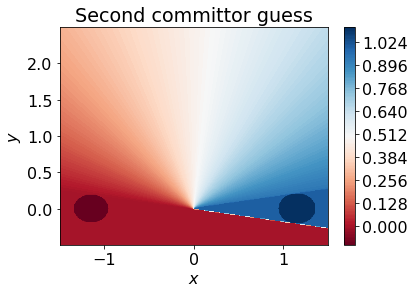

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqCircleU'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b5d83c2f9bf5>", line 50:
@njit(fastmath=True)
def dqCircleU(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


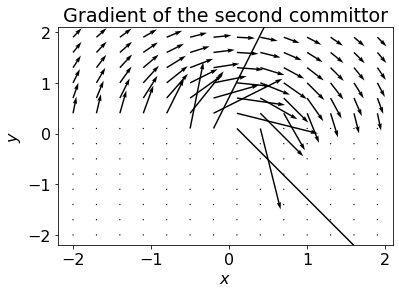

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircleD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b5d83c2f9bf5>", line 66:
@njit(fastmath=True)
def qCircleD(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


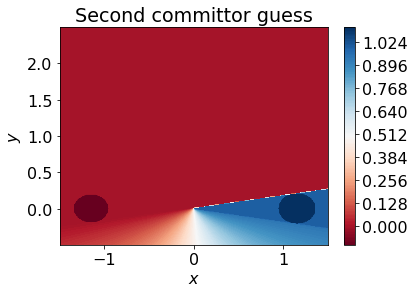

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqCircleD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b5d83c2f9bf5>", line 82:
@njit(fastmath=True)
def dqCircleD(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


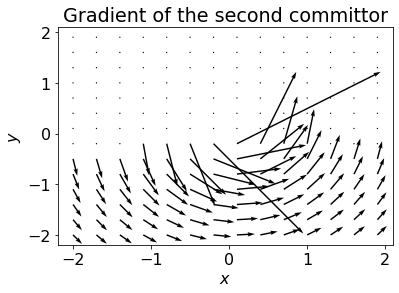

In [10]:
R=0.2

## Second committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircle([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Second committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqCircle([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()     

## Second committor guess function - only up half-plane
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircleU([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Second committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqCircleU([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 


## Second committor guess function - only down half-plane
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qCircleD([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Second committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqCircleD([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 

The third and final committor is a one based on the euclidean distance from the product state (from now on called distance committor). The function that finishes with a 2 considers a bigger region (but has discontinuities)

In [11]:
# Third guess function: euclidian distance between the two states
@njit(fastmath=True)
def qDist(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15-R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.15)**2 + q[1]**2)-R)/(2.0*(1.15-R))
        
@njit(fastmath=True)        
def dqDist(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.15)/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2)), -q[1]/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2))

@njit(fastmath=True)
def qDist2(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.15)**2 + q[1]**2)-R)/(2.0*1.15)
        
@njit(fastmath=True)        
def dqDist2(q, R=0.2):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.15)/(2.0*1.15*np.sqrt((q[0] - 1.15)**2 + q[1]**2)), -q[1]/(2.0*1.15*np.sqrt((q[0] - 1.15)**2 + q[1]**2))

I plot the third committor.

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qDist'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-5011390de023>", line 3:
@njit(fastmath=True)
def qDist(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


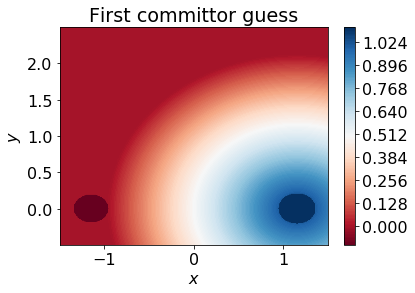

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqDist'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-5011390de023>", line 14:
@njit(fastmath=True)        
def dqDist(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


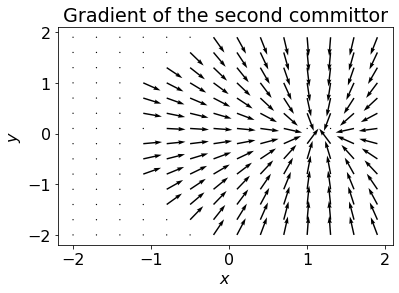

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qDist2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-5011390de023>", line 25:
@njit(fastmath=True)
def qDist2(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


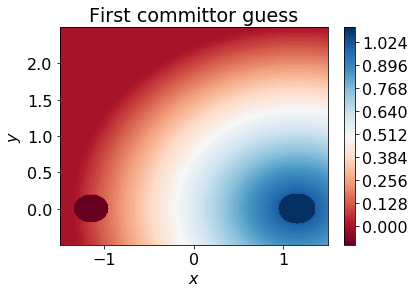

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'dqDist2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-5011390de023>", line 36:
@njit(fastmath=True)        
def dqDist2(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


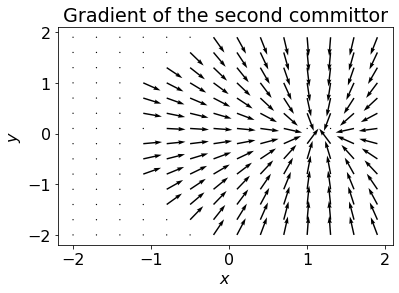

In [12]:
R=0.2

## Third committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qDist([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqDist([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 


## Third committor guess function
# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]

G = np.copy(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = 1.1
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            G[i,j] = -0.1
        else:
            G[i,j] = qDist2([x[i,j], y[i,j]], R=R)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
G = G[:-1, :-1]
levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., G, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('First committor guess')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Gradient of the second committor
x,y = np.meshgrid(np.arange(-2.0,2.0,0.3),np.arange(-2.0,2.0,0.3))

Gx = np.copy(x)
Gy = np.copy(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
            Gx[i,j] = 0.0
            Gy[i,j] = 0.0
        else:
            Gx[i,j], Gy[i,j] = dqDist2([x[i,j], y[i,j]], R=R)
        
# Plot of force field
plt.figure()
plt.quiver(x,y,Gx,Gy, units='width')
plt.title("Gradient of the second committor")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show() 

Finally I define a function to plot the linear combination of two committor guesses, given the coefficients of the linear combination. 

In [13]:
def comm_plot(Guess1, Guess2, c = [0.5, 0.5], R = 0.2):
    # Resolution of the plot
    dx, dy = 0.01, 0.01
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),slice(-1.5, 1.5 + dx, dx)]
    # Plot the committor
    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # Product state
            if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            # Reactant state
            elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = c[0]*Guess1([x[i,j], y[i,j]], R=R) + c[1]*Guess2([x[i,j], y[i,j]], R=R)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # contours are *point* based plots, so convert our bound into point centers
    plt.figure()
    plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
    plt.colorbar(cf, ax=ax)
    # Title and labels
    plt.title('Committor with coefficients '+str(c))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

I also copy the code to plot the histogram of the probability density from the previous notebooks.

In [14]:
def plot_prob_distr(trajectories, xedge, yedge, delta, ncontour):
    ## Density plot of how much time the system passes in a given point
    # Borders of the plot
    xedges = np.arange(xedge[0],xedge[1], delta).tolist()
    yedges = np.arange(yedge[0],yedge[1], delta).tolist()
    # Load the data
    x = trajectories[:,0]
    y = trajectories[:,1]
    # Create the histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
    H = H.T  # Let each row list bins with common y range.
    plt.figure()
    im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax = plt.gca()
    # colormap, colorbar, labels, ect.
    im.set_cmap('RdBu')
    # contour lines
    x = np.arange(xedge[0],xedge[1], 0.025)
    y = np.arange(yedge[0],yedge[1], 0.025)
    X, Y = np.meshgrid(x, y)
    # Identity matrix
    I = X*0+1
    # Probability of the 
    U1 = u0*(np.exp(-(X**2 + Y**2)) - 3.0/5.0*np.exp(-(X**2 + (Y - b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
    U2 = w0*(X**4 + (Y - a0*I)**4)
    Z = np.exp(-KBT*(U1 + U2))
    CS = plt.contour(X, Y, Z, ncontour, colors='k')
    # labels and title
    plt.title("Sampling transition region")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    plt.show()

## Integrator

Here I copy the code of the ratchet-and-pawl that I coded in the notebooks "2D_Toymodel". 

The main differences are the fact that the system starts on the upper-right quarter border of the reactant state (uniform distribution). Moreover at each step I keep saved the following quantity:
\begin{equation}
    M_{\alpha \beta} = \nabla R_\alpha (x) \nabla R_\beta (x)
\end{equation}
where $R_\alpha (x)$ is a committor guess. 

The function takes as input the two committor guesses and their derivative. Moreover we can specify the coefficients of the linear combination (otherwise they are set to $c = [0.5, 0.5]$.

In [15]:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i,:])
        # Linear combination of committors
        z0 = Guess1(q[i,:], R)
        z1 = Guess2(q[i,:], R)
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1, dGy1 = dGuess1(q[i,:], R)
        dGx2, dGy2 = dGuess2(q[i,:], R)
        # Matrix M
        M[i,0,0] = dGx1**2 + dGy1**2
        M[i,1,0] = dGx2*dGx1+dGy2*dGy1
        M[i,0,1] = dGx1*dGx2+dGy1*dGy2
        M[i,1,1] = dGx2**2 + dGy2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*(c[0]*dGy1 + c[1]*dGy2)*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

Now I plot the trajectories. This cell is useful to see what happens when we choose some committor guesses and other coefficients.

In [16]:
# Parameters of the run
KR = 150
KBT = 0.15

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-15-091d55130bcd>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


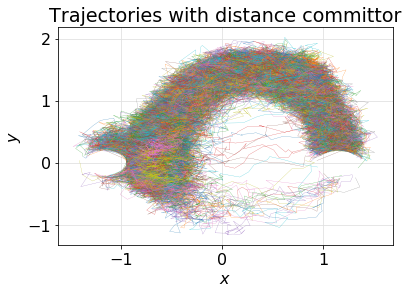

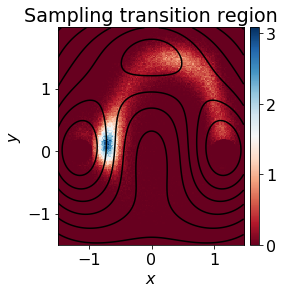

In [17]:
## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qDist, dGuess2 = dqDist, c = [1.0, 0.0],kr = KR, KbT = KBT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-1.5, 2.0], 0.02, 8)

Now I check what are the optimal coefficients of the linear combination (without constraints). As we will see, sometimes the coefficients becomes negative (so we get a not well defined committor). If you want to plot the final result, change the arguments of the "comm_plot" function.

M
[[0.13469934 0.10621914]
 [0.10621914 0.15169662]]
c=  [0.6149122 0.3850878]


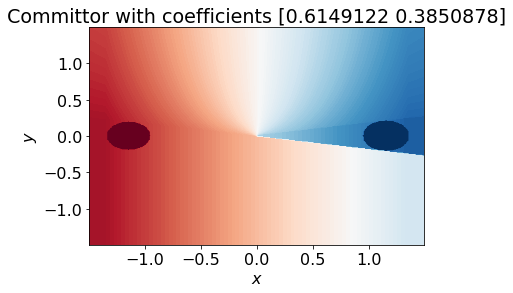

In [18]:
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

# Compute the new coefficients c  
cout = np.zeros(2)
cout[0]=M[1,1] - M[0,1]
cout[1]=M[0,0] - M[1,0]
cout /= np.sum(cout)

print("c= ",cout)

# Make a plot of the committor
comm_plot(Guess1 = qLin2, Guess2 = qCircleU, c = cout)

Now I define the functions for the minimization. "I" calculates the scalar functional I, "I_der" calculates the jacobian and "I_hess" the hessian. At the end I fix the bonds of the minimization (check the documentation of scipy.minimize).

In [19]:
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

Let's see what we get when we fix the constraints.

In [20]:
res = minimize(I, [1.0, 1.0],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 7, CG iterations: 6, optimality: 1.98e-09, constraint violation: 0.00e+00, execution time: 0.17 s.
[0.61489513 0.38510487]


Now I convert the code of the many Langevin trajectories and the minimization in a function. Unfortunately, scipy is not supported by numba (I am looking for better solution to speed up the code. For sure early or later I will parallelize the code).

In [21]:
def Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

Check if the code works.

In [22]:
c = Boltz_sample(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleU, dGuess2 = dqCircleU, c = [0.5, 0.5],kr=100)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-15-091d55130bcd>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[9.99618122e-01 3.81877712e-04]


Finally I set up the self consistent procedure. In order to avoid oscillations, at each iteration I use as coefficients of the linear combination a mix of the previous 2 iterations:
\begin{equation}
    \mathbf{c}_{n+1} = \alpha \mathbf{c}_{n} + (1 - \alpha) \mathbf{c}_{n-1}
\end{equation}
Empirically I checked that $\alpha = 0.5$ gives a good convergence. 

In [23]:
def Self_consistent(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

Now I run the self consistent algorithm.

In [24]:
# Parameters of the run
KBT = 0.15
KR = 150
GUESS1 = qCircleU
DGUESS1 = dqCircleU
GUESS2 = qDist
DGUESS2 = dqDist

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-15-091d55130bcd>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30


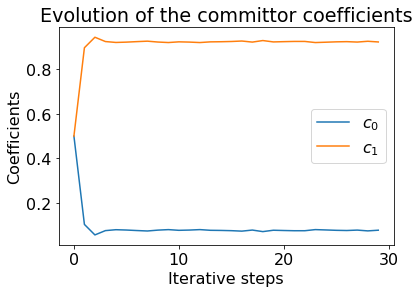

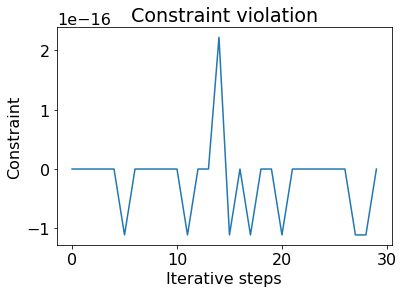

Final coefficients
[0.07880664 0.92119336]


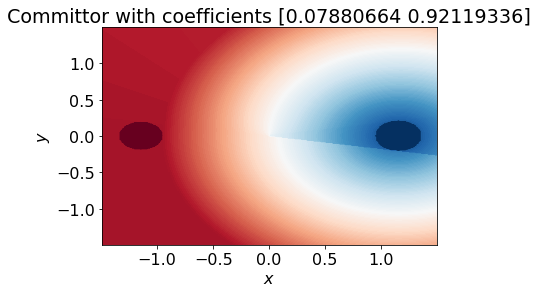

In [25]:
# Self consistent procedure
c = Self_consistent(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
plt.plot(c[:,0], label = r"$c_0$")
plt.plot(c[:,1], label = r"$c_1$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure()
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
comm_plot(Guess1 = GUESS1, Guess2 = GUESS2, c = c[-1,:])

Now I plot the what trajectories we get with the final committor.

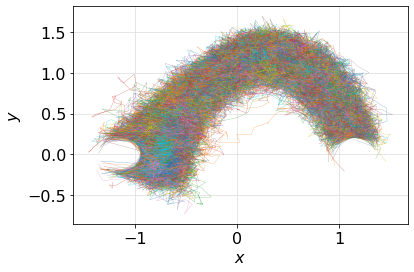

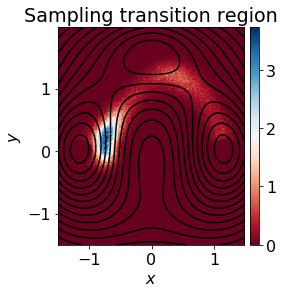

In [26]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMD(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2, c = c[-1,:], kr = KR, KbT = KBT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title,labels and grid
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

## Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-1.5, 2.0], 0.02, 15)

## Second proposal: squared coefficients

Now I consider a linear combination but with squared coefficients. Pretty much I adapt the code of the linear part, the main difference is when we do the minimization procedure. 

In [27]:
def comm_plot2(Guess1, Guess2, c = [np.sqrt(0.5), np.sqrt(0.5)], R = 0.2):
    # Resolution of the plot
    dx, dy = 0.01, 0.01
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),slice(-1.5, 1.5 + dx, dx)]
    # Plot the committor
    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # Product state
            if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            # Reactant state
            elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = c[0]**2*Guess1([x[i,j], y[i,j]], R=R) + c[1]**2*Guess2([x[i,j], y[i,j]], R=R)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # contours are *point* based plots, so convert our bound into point centers
    plt.figure()
    plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
    plt.colorbar(cf, ax=ax)
    # Title and labels
    plt.title('Committor with coefficients '+str(c))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

In [28]:
@njit(fastmath=True)
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    # Assign initial position to the border of the reactant state
    r = random.random_sample()
    # I just precompute the square of the coefficients to speed up the code
    c02 = c[0]**2
    c12 = c[1]**2
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    z0 = Guess1(q[0,:], R)
    z1 = Guess2(q[0,:], R)
    zmax = c02*z0+c12*z1
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i,:])
        # Linear combination of committors
        z0 = Guess1(q[i,:], R)
        z1 = Guess2(q[i,:], R)
        z = c02*z0+c12*z1
        # Gradient components of the committors
        dGx1, dGy1 = dGuess1(q[i,:], R)
        dGx2, dGy2 = dGuess2(q[i,:], R)
        # Matrix M
        M[i,0,0] = dGx1**2 + dGy1**2
        M[i,1,0] = dGx2*dGx1+dGy2*dGy1
        M[i,0,1] = dGx1*dGx2+dGy1*dGy2
        M[i,1,1] = dGx2**2 + dGy2**2
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*(c02*dGx1 + c12*dGx2)*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*(c02*dGy1 + c12*dGy2)*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-28-dc3d3494bb95>", line 2:
@njit(fastmath=True)
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


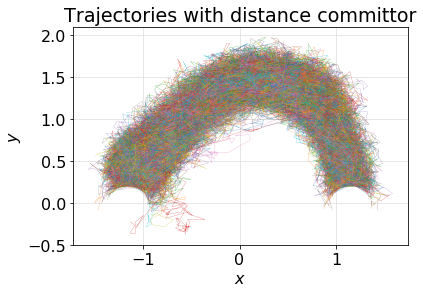

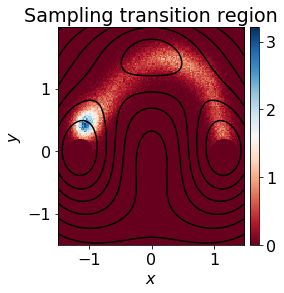

In [29]:
## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD2(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleU, dGuess2 = dqCircleU, c = [np.sqrt(0.5), np.sqrt(0.5)])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-1.5, 2.0], 0.02, 8)

Now I define the functions used in the minimization procedure.

In [30]:
@njit(fastmath=True)
def I2(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[i]*c[j]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I2_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]*c[j]
        Iout[i] *= 4.0*c[i]
    return Iout

@njit(fastmath=True,parallel=True)
def I2_hess(c,M):
    Iout = np.zeros_like(M)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i,j] = 8.0*M[i,j]*c[i]*c[j]
            if i == j:
                for k in range(len(c)):
                    Iout[i,j] += 4.0*M[i,k]*c[k]*c[k]
    return Iout

Constraints used in the minimization (now they are not linear, so it is a bit more complicate. Check the scipy.minimize documentation).

In [31]:
def cons_f(x):
    return [x[0]**2 + x[1]**2]

def cons_J(x):
    return [2*x[0], 2*x[1]]

def cons_H(x, v):
    return v[0]*np.array([2, 2])

nonlinear_constraint = NonlinearConstraint(cons_f, 1, 1, jac=cons_J, hess=cons_H)

Let's see what we get.

In [32]:
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

M
[[0.09302349 0.11112687]
 [0.11112687 0.36156277]]


In [33]:
res = minimize(I2, [1.0, 1.0],M, method='trust-constr', jac=I2_der, hess=I2_hess,
               constraints=nonlinear_constraint,
               options={'verbose': 1})

print(res.x)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-30-d4da0ab1bd59>", line 10:
@njit(fastmath=True,parallel=True)
def I2_der(c,M):
^

  state.func_ir.loc))
/home/francesco/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-30-d4da0ab1bd59>", line 19:
@njit(fastmath=True,parallel=True)
def I2_hess(c,M):
^

  state.func_ir.loc))


`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 14, CG iterations: 13, optimality: 1.84e-12, constraint violation: 1.31e-11, execution time: 0.16 s.
[1.00000000e+00 2.53721332e-11]


Now I convert the code of the many Langevin trajectories and the minimization in a function. Unfortunately, scipy is not supported by numba (I am looking for better solution to speed up the code. For sure early or later I will parallelize the code).

In [34]:
def Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c, R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization procedure
    cout = minimize(I2, [1.0, 1.0],M, method='trust-constr', jac=I2_der, hess=I2_hess,
               constraints=nonlinear_constraint,
               options={'verbose': 0})
    
    return np.array(cout.x)

Let's check that the code works.

In [35]:
c = Boltz_sample2(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircleU, dGuess2 = dqCircleU, kr=100, c = [np.sqrt(0.5), np.sqrt(0.5)])
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-28-dc3d3494bb95>", line 2:
@njit(fastmath=True)
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[ 1.00000000e+00 -3.14572549e-08]


Finally I set up the self consistent procedure.

In [36]:
def Self_consistent2(Guess1, dGuess1, Guess2, dGuess2, c = [np.sqrt(0.5), np.sqrt(0.5)], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # I keep the starting coefficients
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c = np.sqrt(alpha*cout[k+1,:]**2 + (1.0 - alpha)*cout[k,:]**2), R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

Now I run the self consistent algorithm.

In [37]:
# Parameters of the run
KBT = 0.15
KR = 150
GUESS1 = qCircleU
DGUESS1 = dqCircleU
GUESS2 = qDist
DGUESS2 = dqDist

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-28-dc3d3494bb95>", line 2:
@njit(fastmath=True)
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30


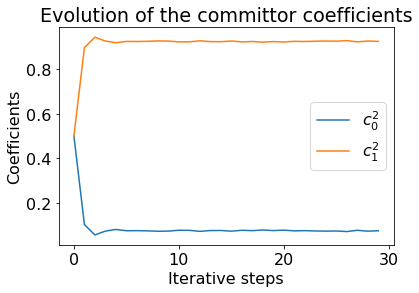

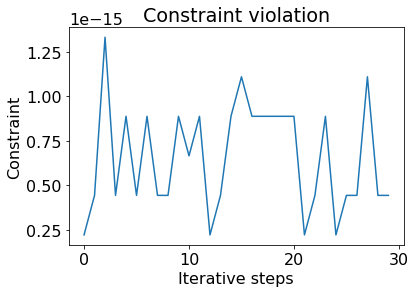

Final coefficients
[0.07756032 0.92243968]


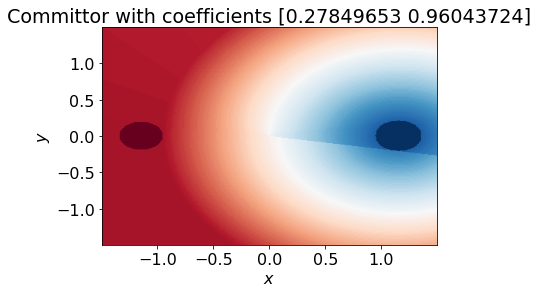

In [38]:
c = Self_consistent2(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [np.sqrt(0.5), np.sqrt(0.5)], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
plt.plot(c[:,0]**2, label = r"$c_0^2$")
plt.plot(c[:,1]**2, label = r"$c_1^2$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(len(c[:,0])):
    constraint[i] = c[i,0]**2+c[i,1]**2-1.0
plt.figure()
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:]**2)
# Print the corresponding committor
comm_plot2(Guess1 = GUESS1, Guess2 = GUESS2, c = c[-1,:])

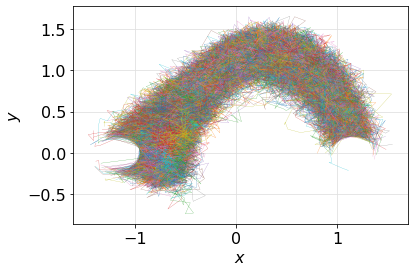

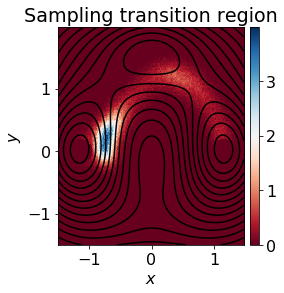

In [39]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMD2(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2, c = c[-1,:], kr = KR, KbT = KBT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title,labels and grid
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

## Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-1.5, 2.0], 0.02, 15)

## Generalization of the code to n committors

Now I want to consider an arbitrary number of committors. 

I did not know very well how to write a function with an arbitrary number of functions as input, so I opted in defining two functions "ListGuess" and "ListdGuess" that must contain all the committor guesses that I want to use. If there is a more elegant way to do this, tell me :)

In [40]:
@njit(fastmath=True)
def ListGuess(n, q, R=0.2):
    if n == 0:
        return qLin(q,R)
    elif n == 1:
        return qCircleU(q,R)
    else:
        return qDist(q,R)
    
@njit(fastmath=True)
def ListdGuess(n, q, R=0.2):
    if n == 0:
        return dqLin(q,R)
    elif n == 1:
        return dqCircleU(q,R)
    else:
        return dqDist(q,R)

In [41]:
def comm_plotN(c, R = 0.2):
    n = len(c)
    # Resolution of the plot
    dx, dy = 0.01, 0.01
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),slice(-1.5, 1.5 + dx, dx)]
    # Plot the committor
    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # Product state
            if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            # Reactant state
            elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = 0.0
                for k in range(n):
                    G[i,j] += c[k]*ListGuess(k, [x[i,j],y[i,j]], R=R)

    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # contours are *point* based plots, so convert our bound into point centers
    plt.figure()
    plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
    plt.colorbar(cf, ax=ax)
    # Title and labels
    plt.title('Committor with coefficients '+str(c))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

In [42]:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None,  R =0.2, dt = 0.02, KbT = 0.15, kr = 150, isteps = 4000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,n,n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i,:], R)
        # Gradient components of the committors
        for k in range(n):
            dGx[k], dGy[k] = ListdGuess(k, q[i,:], R)  
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            ratchetx = 0.0
            ratchety = 0.0
            for k in range(n):
                ratchetx += c[k]*dGx[k]
                ratchety += c[k]*dGy[k]
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*ratchetx*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*ratchety*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                M[i,k,l] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

Let's run the integrator and see what we get.

In [43]:
KR = 150
KBT = 0.15

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-42-1d9e492a0802>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None,  R =0.2, dt = 0.02, KbT = 0.15, kr = 150, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


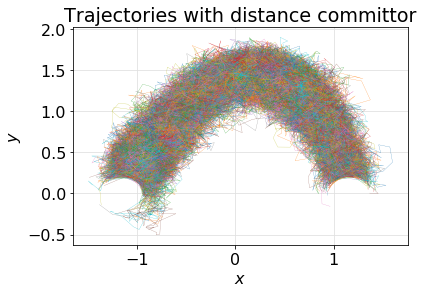

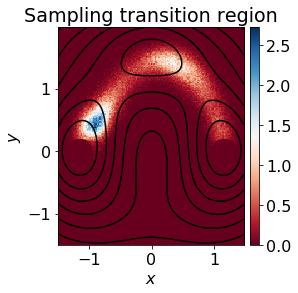

In [44]:
## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMDN(c = [1.0/3.0, 1.0/3.0, 1.0/3.0], kr = KR, KbT = KBT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with distance committor')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


### Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-1.5, 2.0], 0.02, 8)

Now I do the minimization procedure. First I define the constraints.

In [45]:
bounds = Bounds([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0, 1.0], 1.0, 1.0)

In [46]:
def Boltz_sampleN(c, R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMDN(c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    n = len(c)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0, 0.0], [1.0, 1.0, 1.0]))
    
    
    return np.array(cout.x)


def Self_consistentN(c , R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sampleN(c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sampleN(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

Let's check that the code works

In [47]:
c = Boltz_sampleN(c = [1.0/3.0, 1.0/3.0, 1.0/3.0], kr = 150)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-42-1d9e492a0802>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None,  R =0.2, dt = 0.02, KbT = 0.15, kr = 150, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[6.43980054e-01 1.06114869e-04 3.55913831e-01]


In [48]:
# Parameters of the run
KBT = 0.15
KR = 150

Cycle =  1
Cycle =  2
Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30


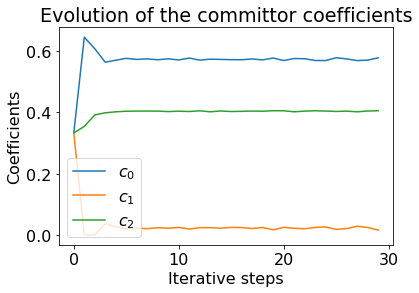

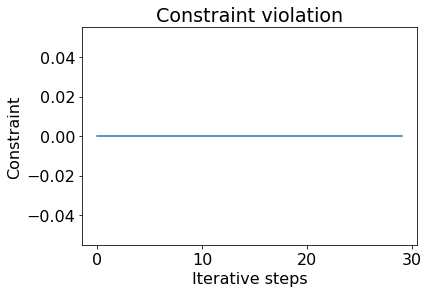

Final coefficients
[0.57847501 0.01579687 0.40572812]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'ListGuess'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-40-f2284a8958b0>", line 2:
@njit(fastmath=True)
def ListGuess(n, q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


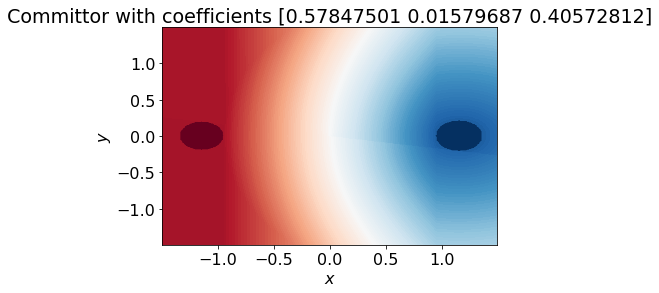

In [49]:
# Self consistent procedure
c = Self_consistentN(c = [1.0/3.0, 1.0/3.0, 1.0/3.0], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
for i in range(c.shape[1]):
    plt.plot(c[:,i], label = r"$c_{}$".format(i))
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(c.shape[1]):
    constraint[i] = np.sum(c[i,:])-1.0
plt.figure()
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
comm_plotN(c = c[-1,:])

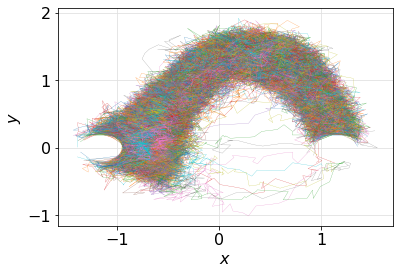

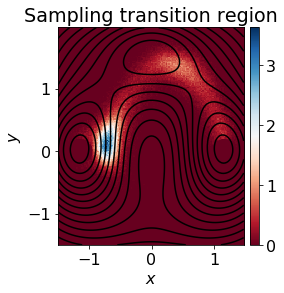

In [50]:
# Figure
plt.figure()
tmp = 0
for i in range(1000):
    traj, M = LI_RMDN(c = c[-1,:], kr = KR, KbT = KBT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title,labels and grid
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

## Probability density plot
plot_prob_distr(trajall, [-1.5, 1.5], [-1.5, 2.0], 0.02, 15)